In [1]:
from io import BytesIO

import clip
import numpy as np
import pandas as pd
import requests
import torch
from PIL import Image
from sklearn.metrics.pairwise import cosine_similarity

# embeddings: https://deploy.laion.ai/8f83b608504d46bb81708ec86e912220/embeddings/img_emb/img_emb_0.npy
# parquet: https://deploy.laion.ai/8f83b608504d46bb81708ec86e912220/embeddings/metadata/metadata_0.parquet


In [2]:
# !aria2c https://deploy.laion.ai/8f83b608504d46bb81708ec86e912220/embeddings/img_emb/img_emb_0.npy
# !aria2c https://deploy.laion.ai/8f83b608504d46bb81708ec86e912220/embeddings/metadata/metadata_0.parquet
# !aria2c https://deploy.laion.ai/8f83b608504d46bb81708ec86e912220/embeddings/text_emb/text_emb_0.npy

In [3]:
img_emb = np.load('multimodal_embeddings/img_emb/img_emb_0.npy')
text_emb = np.load('multimodal_embeddings/text_emb/text_emb_0.npy')
print(img_emb.shape, text_emb.shape)

(1000448, 512) (1000448, 512)


In [4]:
# Elementwise combination for multimodal embeddings
w1 = 0.5
w2 = 0.5

def normalized(a, axis=-1, order=2):
    l2 = np.atleast_1d(np.linalg.norm(a, order, axis))
    l2[l2 == 0] = 1
    return a / np.expand_dims(l2, axis)

multimodal_emb = normalized(w1*img_emb + w2*text_emb)

In [5]:
np.save('multimodal_embeddings/combined_emb/combined_emb.npy', multimodal_emb)

In [6]:
## Build sample Index
!autofaiss build_index --embeddings="multimodal_embeddings/combined_emb" \
                    --index_path="combined.index" \
                    # --index_infos_path="infos.json" \
                    --metric_type="ip" \
                    --max_index_query_time_ms=5 
                    # \
                    # --max_index_memory_usage="1GB"

2024-07-09 21:17:30,981 [INFO]: Using 12 omp threads (processes), consider increasing --nb_cores if you have more
2024-07-09 21:17:30,981 [INFO]: Launching the whole pipeline 07/09/2024, 21:17:30
2024-07-09 21:17:30,981 [INFO]: Reading total number of vectors and dimension 07/09/2024, 21:17:30
100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 2077.42it/s]
2024-07-09 21:17:30,999 [INFO]: There are 1000448 embeddings of dim 512
2024-07-09 21:17:31,000 [INFO]: >>> Finished "Reading total number of vectors and dimension" in 0.0185 secs
2024-07-09 21:17:31,000 [INFO]: 	Compute estimated construction time of the index 07/09/2024, 21:17:31
2024-07-09 21:17:31,000 [INFO]: 		-> Train: 16.7 minutes
2024-07-09 21:17:31,000 [INFO]: 		-> Add: 5.7 seconds
2024-07-09 21:17:31,000 [INFO]: 		Total: 16.8 minutes
2024-07-09 21:17:31,000 [INFO]: 	>>> Finished "Compute estimated construction time of the index" in 0.0002 secs
2024-07-09 21:17:31,000 [INFO]: 	Checking that your have enough 

In [7]:
import faiss
import numpy as np
# check this for text and do a compare between text and image combined
img_ind = faiss.read_index("img.index")
text_ind = faiss.read_index("text.index")
combined_ind = faiss.read_index("combined.index")

In [8]:
from pathlib import Path
import pandas as pd
data_dir = Path("embeddings")
df = pd.concat(
    pd.read_parquet(parquet_file)
    for parquet_file in data_dir.glob('*.parquet')
)
print(df.head(2))
image_list = df["image_path"].tolist()
caption_list = df["caption"].tolist()
url_list = df["url"].tolist()

  image_path                                            caption      NSFW  \
0  000000033  2 bed Terraced property to rent in Crofts Lane...  UNLIKELY   
1  000000044  Teleflora's Simply Sweet in Cleveland TN, Jimm...  UNLIKELY   

   similarity LICENSE                                                url  key  \
0    0.333244       ?  http://media.rightmove.co.uk/dir/87k/86030/419...   33   
1    0.301415       ?  http://images.shopflowers.net/images/products/...   44   

   shard_id   status error_message  width  height exif  original_width  \
0     19848  success          None    256     256   {}             191   
1     19848  success          None    256     256   {}             274   

   original_height  
0              143  
1              300  


In [9]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

Text to Text query

In [10]:
text = "Black kitten walking"
text_tokens = clip.tokenize([text], truncate=True)

text_features = model.encode_text(text_tokens.to(device))
text_features /= text_features.norm(dim=-1, keepdim=True)
text_embeddings = text_features.cpu().detach().numpy().astype('float32')

print("="*10)
print("text query = {}".format(text))

D, I = text_ind.search(text_embeddings, 5)
print("results :")
output = []
for d, i in zip(D[0], I[0]):
  output.append({
    "Similarity": d,
    "Index": i,
    "Caption": caption_list[i],
    "Image url": url_list[i],
  })
  print("Similarity= ", d)
  print("Index ={}".format(i))
  print("Caption ={}".format(caption_list[i]))
  print("Image url = {}".format(url_list[i]))
  print(" ")

text query = Black kitten walking
results :
Similarity=  1.0001161
Index =674116
Caption =Black kitten walking
Image url = https://www.warrenphotographic.co.uk/photography/rubs/15469.jpg
 
Similarity=  0.8817433
Index =869999
Caption =Black cat crossing my path
Image url = https://images.squarespace-cdn.com/content/5b96bcab25bf02e0c973cb45/1536613271759-TE0MV6KGZDMQL88ED2SO/Black_Cat-e1438892816170.jpg?content-type=image%2Fjpeg
 
Similarity=  0.841198
Index =792188
Caption =cute black kitty photography
Image url = https://www.designyourway.net/diverse/cutefurry/Cheer_me_up_please_by_KateW.jpg
 
Similarity=  0.81187344
Index =368219
Caption =black, black cat, and cat image
Image url = https://data.whicdn.com/images/320934496/superthumb.jpg?t=1539717612
 
Similarity=  0.7961532
Index =309297
Caption =Adorable black little puppy
Image url = http://3.bp.blogspot.com/-bqjySYh3FY0/UchQ8qw2JHI/AAAAAAAAND8/2WgclvIdlok/s1600/72453_546841265338827_2044743145_n.jpg
 


Text to Image query

In [11]:
text = "Black kitten walking"
text_tokens = clip.tokenize([text], truncate=True)

text_features = model.encode_text(text_tokens.to(device))
text_features /= text_features.norm(dim=-1, keepdim=True)
text_embeddings = text_features.cpu().detach().numpy().astype('float32')

print("="*10)
print("text query = {}".format(text))

D, I = img_ind.search(text_embeddings, 5)
print("results :")
for d, i in zip(D[0], I[0]):
  print("Similarity= ", d)
  print("Index ={}".format(i))
  print("Caption ={}".format(caption_list[i]))
  print("Image url = {}".format(url_list[i]))
  print(" ")

text query = Black kitten walking
results :
Similarity=  0.34802148
Index =674116
Caption =Black kitten walking
Image url = https://www.warrenphotographic.co.uk/photography/rubs/15469.jpg
 
Similarity=  0.34557217
Index =881316
Caption =Kittens Getting Lunch - Video
Image url = https://i.rmbl.ws/s8/6/k/f/t/t/kftta.0kob.1.jpg
 
Similarity=  0.33044752
Index =869999
Caption =Black cat crossing my path
Image url = https://images.squarespace-cdn.com/content/5b96bcab25bf02e0c973cb45/1536613271759-TE0MV6KGZDMQL88ED2SO/Black_Cat-e1438892816170.jpg?content-type=image%2Fjpeg
 
Similarity=  0.32493633
Index =50660
Caption =Cute black kitten going in a spacious yard on a sunny day in summer in slo-mo Live Action
Image url = https://d1o2pwfline4gu.cloudfront.net/m/t/13398/13388247/a-0266.jpg
 
Similarity=  0.3132999
Index =131603
Caption =salya : Black cat washes paws with language. Stok Video
Image url = https://vidcdn.123rf.com/450nwm/zoteva87/zoteva871612/zoteva87161200118.jpg
 


Image to Image query

query :


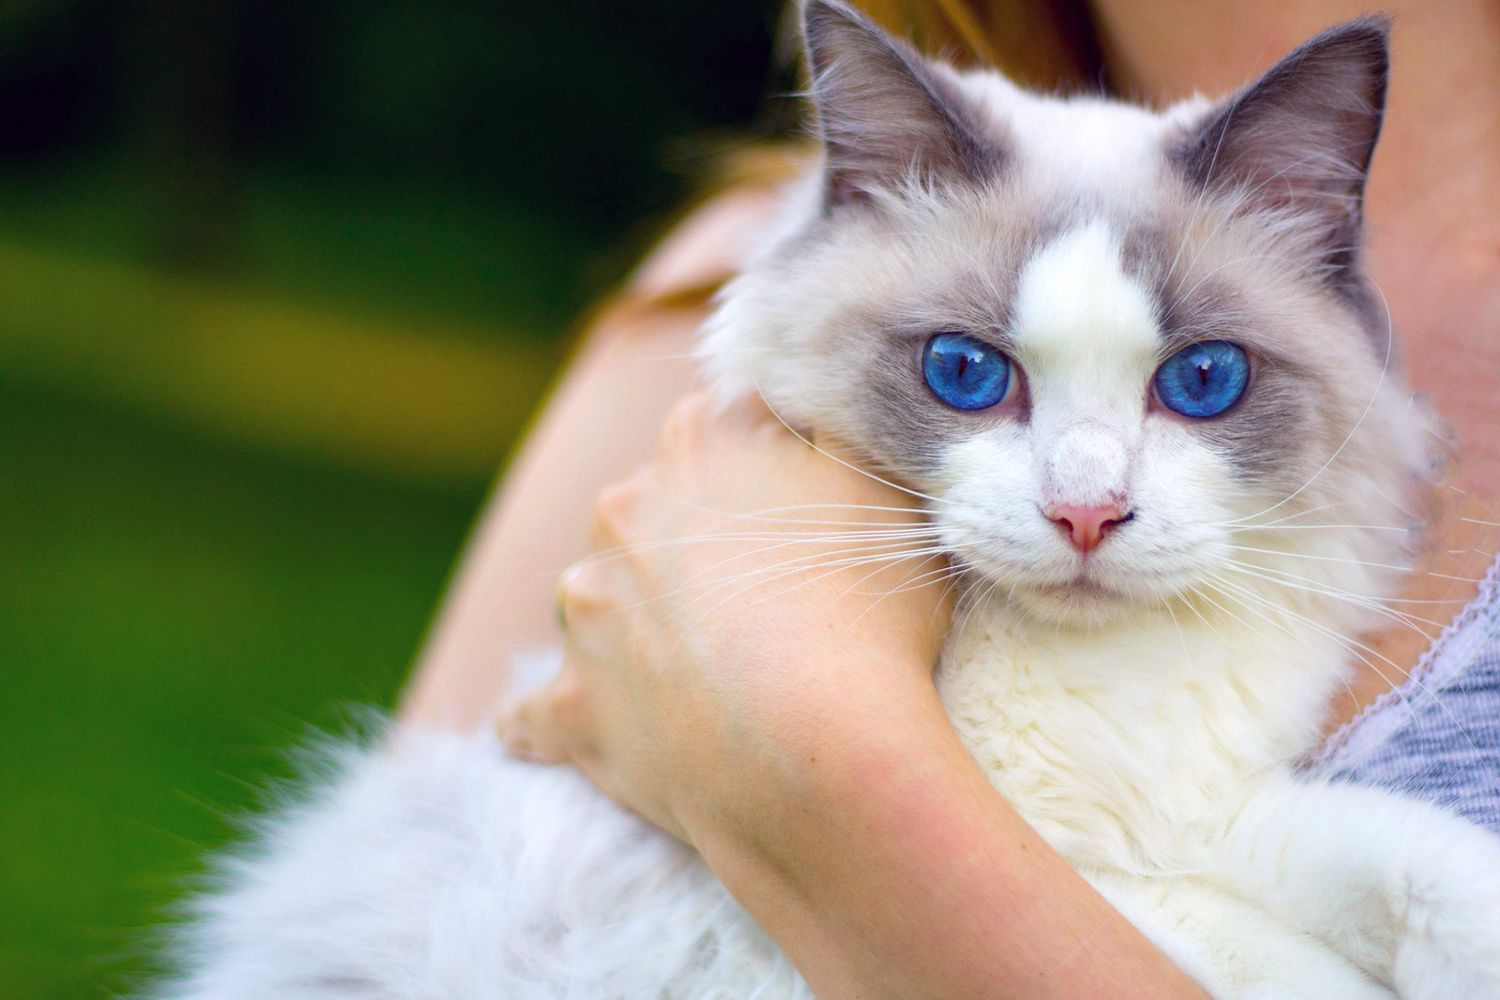

results :
Similarity=  0.8555026
Index =53913
Caption =cat, white, and eyes image
Image url = https://data.whicdn.com/images/209379605/superthumb.jpg?t=1447926717
 
Similarity=  0.84369767
Index =478216
Caption =himalayan cat: Cat isolated over white background
Image url = https://us.123rf.com/450wm/satina/satina1003/satina100301562/6615526-cat-isolated-over-white-background.jpg?ver=6
 
Similarity=  0.83305585
Index =882682
Caption =White Cat Breeds
Image url = https://petsaw.com/wp-content/uploads/2020/04/dreamstime_xxl_13363170_edit.jpg
 
Similarity=  0.8330202
Index =707221
Caption =himalayan cat: Cat isolated Stock Photo
Image url = https://us.123rf.com/450wm/satina/satina1003/satina100300530/6574357-cat-isolated.jpg?ver=6
 
Similarity=  0.8267983
Index =134746
Caption =Pretty Ragdoll cat on white background Royalty Free Stock Image
Image url = https://thumbs.dreamstime.com/t/pretty-ragdoll-cat-white-background-10310986.jpg
 


In [12]:
from PIL import Image

image = Image.open("newcat.jpg")
image_tensor = preprocess(image)

image_features = model.encode_image(torch.unsqueeze(image_tensor.to(device), dim=0))
image_features /= image_features.norm(dim=-1, keepdim=True)

image_embeddings = image_features.cpu().detach().numpy().astype('float32')

print("query :")
display(image) 

D, I = img_ind.search(image_embeddings, 5)
print("results :")
for d, i in zip(D[0], I[0]):
  print("Similarity= ", d)
  print("Index ={}".format(i))
  print("Caption ={}".format(caption_list[i]) )
  print("Image url = {}".format(url_list[i]))
  print(" ")

Image to text query

query :


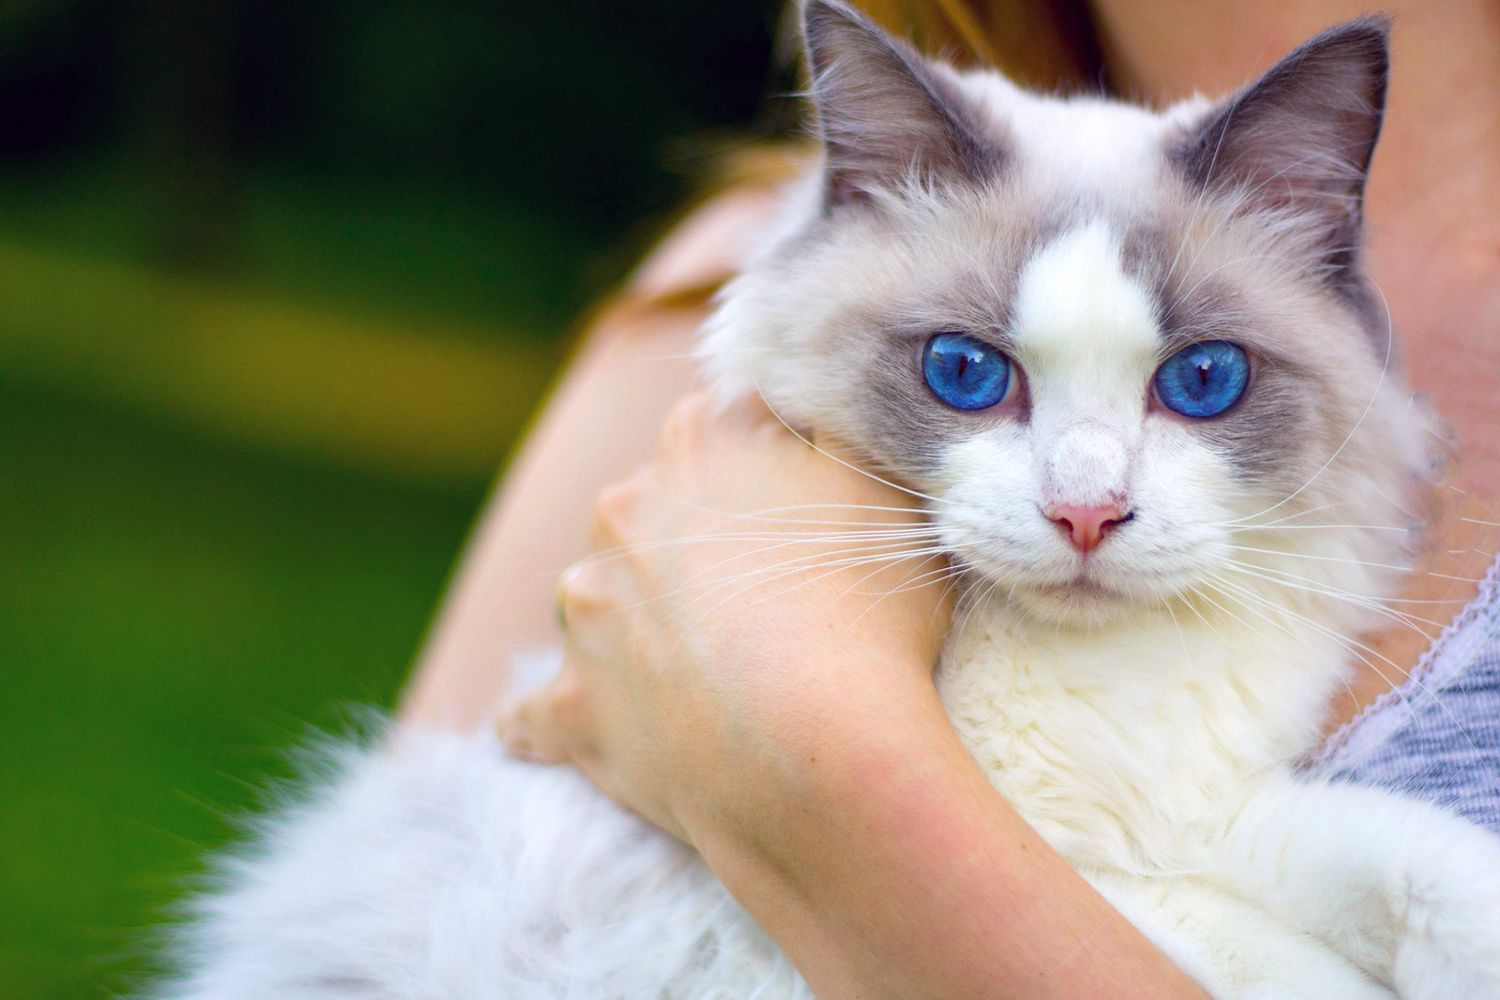

results :
Similarity=  0.32158068
Index =974279
Caption =Animals: Top 10 Most Expensive Cat Breeds In The World!
Image url = https://chirkup.me/images/uploaded/00/01/41/14166_800x.jpg
 
Similarity=  0.31387198
Index =467036
Caption =A Complete Guide To Long Haired Cat Breeds, Their Care And Grooming
Image url = https://www.thehappycatsite.com/wp-content/uploads/2017/07/1.jpg
 
Similarity=  0.31361276
Index =447402
Caption =5 Reasons to Test Your Cat for Diabetes
Image url = https://diabetestalk.net/images/nzOMVyoBArsdRRfx.jpg?w=450&h=270&t=squaredown
 
Similarity=  0.31217146
Index =425653
Caption =Top 10 BIGGEST CAT Breeds
Image url = https://i.ytimg.com/vi/6CXnuenk8L0/hqdefault.jpg
 
Similarity=  0.3108675
Index =797544
Caption =10 Things You Didn't Know About Cats  http://catsnation.blogspot.com:
Image url = https://i.pinimg.com/564x/f3/dd/72/f3dd72625483dea1bf3e2a10964b85e7.jpg
 


In [13]:
from PIL import Image

image = Image.open("newcat.jpg")
image_tensor = preprocess(image)

image_features = model.encode_image(torch.unsqueeze(image_tensor.to(device), dim=0))
image_features /= image_features.norm(dim=-1, keepdim=True)

image_embeddings = image_features.cpu().detach().numpy().astype('float32')

print("query :")
display(image) 

D, I = text_ind.search(image_embeddings, 5)
print("results :")
for d, i in zip(D[0], I[0]):
  print("Similarity= ", d)
  print("Index ={}".format(i))
  print("Caption ={}".format(caption_list[i]) )
  print("Image url = {}".format(url_list[i]))
  print(" ")

Multi modal Image-Text query

query :


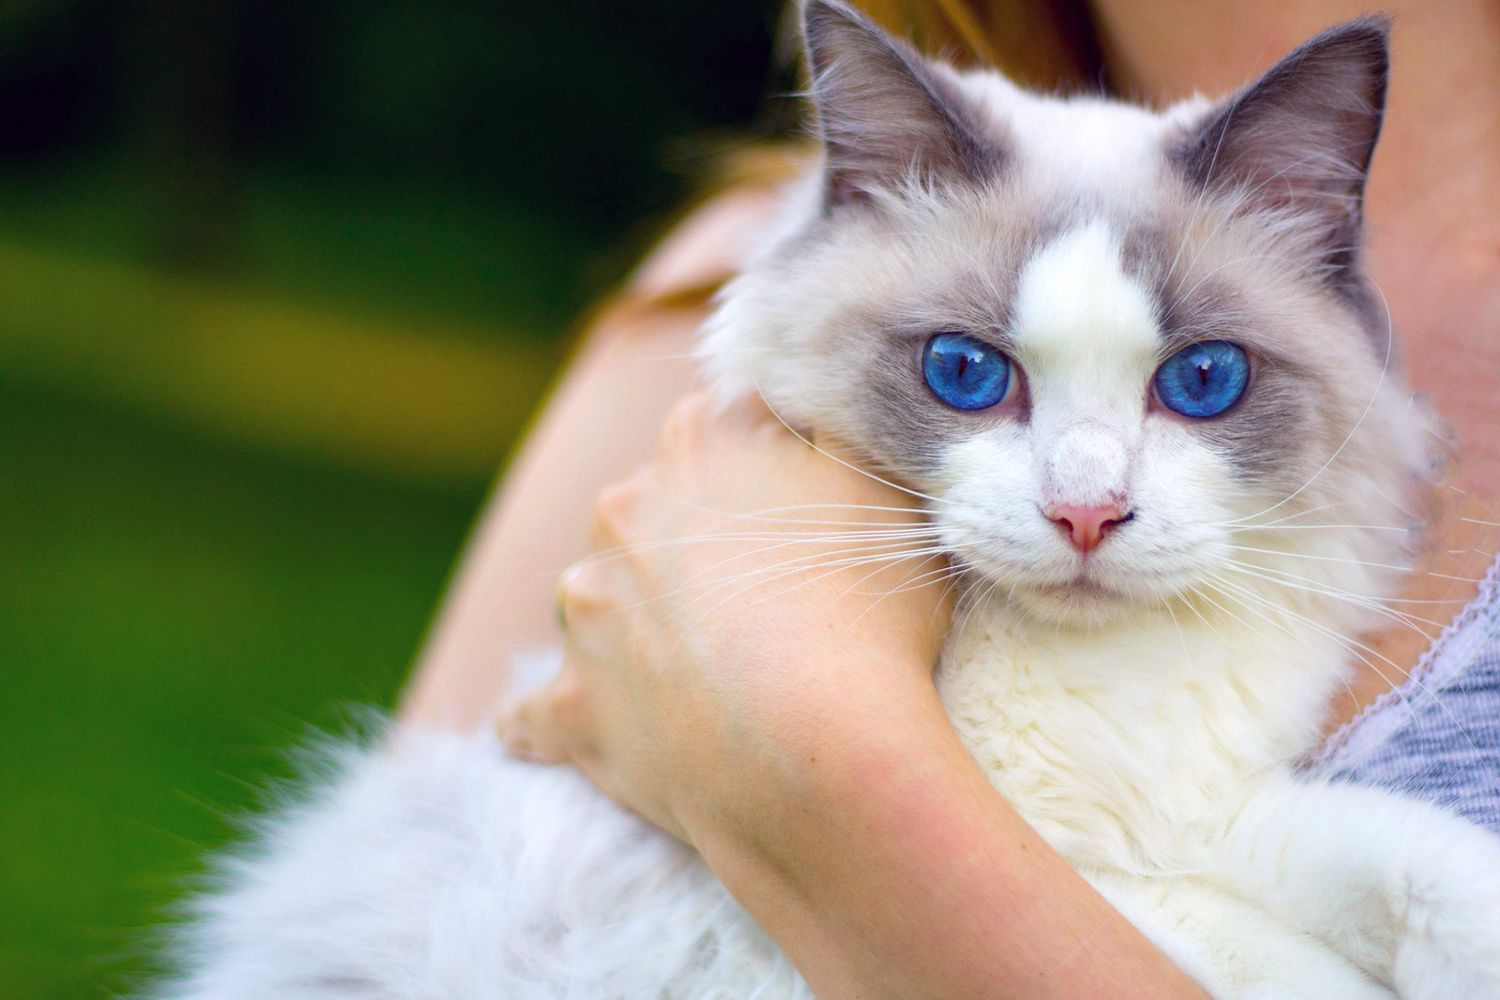

text query = black cat with yellow eyes
results :
Similarity=  0.65644807
Index =355390
Caption =The Bombay is the most commonly depicted breed of black cat.
Image url = https://usercontent2.hubstatic.com/9749795_f520.jpg
 
Similarity=  0.650046
Index =905508
Caption =Portrait of black cat with green eyes
Image url = https://image.shutterstock.com/image-photo/portrait-black-cat-green-eyes-260nw-1126306655.jpg
 
Similarity=  0.64566135
Index =53913
Caption =cat, white, and eyes image
Image url = https://data.whicdn.com/images/209379605/superthumb.jpg?t=1447926717
 
Similarity=  0.64457023
Index =948630
Caption =Fascinating Facts About Black Cats
Image url = https://simplebest.club/wp-content/uploads/2018/05/cat-2448839__340-710x1068.jpg
 
Similarity=  0.64374435
Index =368219
Caption =black, black cat, and cat image
Image url = https://data.whicdn.com/images/320934496/superthumb.jpg?t=1539717612
 


In [14]:
from PIL import Image

image = Image.open("newcat.jpg")
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)
image_tensor = preprocess(image)

image_features = model.encode_image(torch.unsqueeze(image_tensor.to(device), dim=0))
image_features /= image_features.norm(dim=-1, keepdim=True)

image_embeddings = image_features.cpu().detach().numpy().astype('float32')

print("="*10)
print("query :")
display(image) 

text = "black cat with yellow eyes"
text_tokens = clip.tokenize([text], truncate=True)

text_features = model.encode_text(text_tokens.to(device))
text_features /= text_features.norm(dim=-1, keepdim=True)
text_embeddings = text_features.cpu().detach().numpy().astype('float32')

print("="*10)
print("text query = {}".format(text))

combined_embeddings = 0.3 * image_embeddings + 0.7 * text_embeddings

D, I = combined_ind.search(combined_embeddings, 5)
print("results :")
for d, i in zip(D[0], I[0]):
  print("Similarity= ", d)
  print("Index ={}".format(i))
  print("Caption ={}".format(caption_list[i]) )
  print("Image url = {}".format(url_list[i]))
  print(" ")